In [1]:
import esm
import torch
import time
import gc
import os
%run "../scripts/data_processing.py"
%run "../scripts/node_edge_generation.py"
%run "../scripts/graph_functions.py"

#Data path
datadir = os.path.abspath("../../Data/")

### Data retrieval

In [2]:
#Start graph
startGraph("./pass_ent.txt", "./Results/")

#Submit query, retrieve sequences with direct cutaneous leishmaniasis associations
uri = "bolt://localhost:7687" 
driver = GraphDatabase.driver(uri)

query_1 = [f'match (p:Protein)-[di:direct_evidence]-(d:Disease)\n \
            where  d.name contains "cutaneous Leishmaniasis" \
            return p.uniprot as Uniprot, p.name as Prot_nam, toFloat(di.score) as Score, p.seq as Sequence order by Score desc']

results_1 = run_query(query_1[0], driver)
display(results_1)

#Close connection
driver.close()

#Create subset with smaller sequences
smallseqs = results_1.loc[results_1["Sequence"].str.len() <= 1500]

Graph stopped
Database import successful!
Graph started


,Uniprot,Prot_nam,Score,Sequence
0,P01611,Immunoglobulin kappa variable 1D-12,0.586821,MDMMVPAQLLGLLLLWFPGSRCDIQMTQSPSSVSASVGDRVTITCR...
1,P01709,Immunoglobulin lambda variable 2-8,0.586821,MAWALLLLTLLTQGTGSWAQSALTQPPSASGSPGQSVTISCTGTSS...
2,P01814,Immunoglobulin heavy variable 2-70,0.586821,MDILCSTLLLLTVPSWVLSQVTLRESGPALVKPTQTLTLTCTFSGF...
3,P01768,Immunoglobulin heavy variable 3-30,0.586821,MEFGLSWVFLVALLRGVQCQVQLVESGGGVVQPGRSLRLSCAASGF...
4,A2NJV5,Immunoglobulin kappa variable 2-29,0.586821,MRLPAQLLGLLMLWIPGSSADIVMTQTPLSLSVTPGQPASISCKSS...
...,...,...,...,...
244,P11912,B-cell antigen receptor complex-associated pro...,0.001478,MPGGPGVLQALPATIFLLFLLSAVYLGPGCQALWMHKVPASLMVSL...
245,P27361,Mitogen-activated protein kinase 3,0.001478,MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQ...
246,P29965,CD40 ligand,0.001478,MIETYNQTSPRSAATGLPISMKIFMYLLTVFLITQMIGSALFAVYL...
247,P35228,"Nitric oxide synthase, inducible",0.001478,MACPWKFLFKTKFHQYAMNGEKDINNNVEKAPCATSSPVTQDDLQY...


In [15]:
display(smallseqs)
smallseqs.loc[smallseqs["Uniprot"] == "P01611", "Score"] = "Hello" 
display(smallseqs)

,Uniprot,Prot_nam,Score,Sequence
0,P01611,Immunoglobulin kappa variable 1D-12,0.586821,MDMMVPAQLLGLLLLWFPGSRCDIQMTQSPSSVSASVGDRVTITCR...
1,P01709,Immunoglobulin lambda variable 2-8,0.586821,MAWALLLLTLLTQGTGSWAQSALTQPPSASGSPGQSVTISCTGTSS...
2,P01814,Immunoglobulin heavy variable 2-70,0.586821,MDILCSTLLLLTVPSWVLSQVTLRESGPALVKPTQTLTLTCTFSGF...
3,P01768,Immunoglobulin heavy variable 3-30,0.586821,MEFGLSWVFLVALLRGVQCQVQLVESGGGVVQPGRSLRLSCAASGF...
4,A2NJV5,Immunoglobulin kappa variable 2-29,0.586821,MRLPAQLLGLLMLWIPGSSADIVMTQTPLSLSVTPGQPASISCKSS...
...,...,...,...,...
244,P11912,B-cell antigen receptor complex-associated pro...,0.001478,MPGGPGVLQALPATIFLLFLLSAVYLGPGCQALWMHKVPASLMVSL...
245,P27361,Mitogen-activated protein kinase 3,0.001478,MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQ...
246,P29965,CD40 ligand,0.001478,MIETYNQTSPRSAATGLPISMKIFMYLLTVFLITQMIGSALFAVYL...
247,P35228,"Nitric oxide synthase, inducible",0.001478,MACPWKFLFKTKFHQYAMNGEKDINNNVEKAPCATSSPVTQDDLQY...


/tmp/ipykernel_42374/913579257.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Hello' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  smallseqs.loc[smallseqs["Uniprot"] == "P01611", "Score"] = "Hello"


,Uniprot,Prot_nam,Score,Sequence
0,P01611,Immunoglobulin kappa variable 1D-12,Hello,MDMMVPAQLLGLLLLWFPGSRCDIQMTQSPSSVSASVGDRVTITCR...
1,P01709,Immunoglobulin lambda variable 2-8,0.586821,MAWALLLLTLLTQGTGSWAQSALTQPPSASGSPGQSVTISCTGTSS...
2,P01814,Immunoglobulin heavy variable 2-70,0.586821,MDILCSTLLLLTVPSWVLSQVTLRESGPALVKPTQTLTLTCTFSGF...
3,P01768,Immunoglobulin heavy variable 3-30,0.586821,MEFGLSWVFLVALLRGVQCQVQLVESGGGVVQPGRSLRLSCAASGF...
4,A2NJV5,Immunoglobulin kappa variable 2-29,0.586821,MRLPAQLLGLLMLWIPGSSADIVMTQTPLSLSVTPGQPASISCKSS...
...,...,...,...,...
244,P11912,B-cell antigen receptor complex-associated pro...,0.001478,MPGGPGVLQALPATIFLLFLLSAVYLGPGCQALWMHKVPASLMVSL...
245,P27361,Mitogen-activated protein kinase 3,0.001478,MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQ...
246,P29965,CD40 ligand,0.001478,MIETYNQTSPRSAATGLPISMKIFMYLLTVFLITQMIGSALFAVYL...
247,P35228,"Nitric oxide synthase, inducible",0.001478,MACPWKFLFKTKFHQYAMNGEKDINNNVEKAPCATSSPVTQDDLQY...


### Data preparation

In [6]:
#Reset gpu resource usage
torch.cuda.empty_cache()
print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

querydf = smallseqs

# Load ESM-2 model
#https://github.com/facebookresearch/esm#available-models
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()

#Split to test + train datasets
from sklearn.model_selection import train_test_split
print(len(smallseqs["Sequence"].values), len(smallseqs["Uniprot"].values))
train_sequences, test_sequences, train_labels, test_labels = train_test_split(smallseqs["Sequence"].values, smallseqs["Uniprot"].values, test_size=0.25, shuffle=True)

#Prepare sequences for tokenisation
trainlist = []
for i, j in zip(train_labels, train_sequences):
    trainlist.append((i, j))
testlist = []
for i, j in zip(test_labels, test_sequences):
    testlist.append((i, j))

#Check test/train list match Uniprot <> seq labels
res = []
for i in trainlist+testlist:
    res.append(smallseqs.loc[smallseqs["Uniprot"] == i[0]]["Sequence"].values[0] == i[1])
if False in res:
    print("Mismatch!")
else:
    print("All matched!")

Allocated memory: 0.00 MB
Cached memory: 0.00 MB
243 243
All matched!


In [7]:
trainlist

[('P01861',
  'ASTKGPSVFPLAPCSRSTSESTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTKTYTCNVDHKPSNTKVDKRVESKYGPPCPSCPAPEFLGGPSVFLFPPKPKDTLMISRTPEVTCVVVDVSQEDPEVQFNWYVDGVEVHNAKTKPREEQFNSTYRVVSVLTVLHQDWLNGKEYKCKVSNKGLPSSIEKTISKAKGQPREPQVYTLPPSQEEMTKNQVSLTCLVKGFYPSDIAVEWESNGQPENNYKTTPPVLDSDGSFFLYSRLTVDKSRWQEGNVFSCSVMHEALHNHYTQKSLSLSLGK'),
 ('P16410',
  'MACLGFQRHKAQLNLATRTWPCTLLFFLLFIPVFCKAMHVAQPAVVLASSRGIASFVCEYASPGKATEVRVTVLRQADSQVTEVCAATYMMGNELTFLDDSICTGTSSGNQVNLTIQGLRAMDTGLYICKVELMYPPPYYLGIGNGTQIYVIDPEPCPDSDFLLWILAAVSSGLFFYSFLLTAVSLSKMLKKRSPLTTGVYVKMPPTEPECEKQFQPYFIPIN'),
 ('Q9NR96',
  'MGFCRSALHPLSLLVQAIMLAMTLALGTLPAFLPCELQPHGLVNCNWLFLKSVPHFSMAAPRGNVTSLSLSSNRIHHLHDSDFAHLPSLRHLNLKWNCPPVGLSPMHFPCHMTIEPSTFLAVPTLEELNLSYNNIMTVPALPKSLISLSLSHTNILMLDSASLAGLHALRFLFMDGNCYYKNPCRQALEVAPGALLGLGNLTHLSLKYNNLTVVPRNLPSSLEYLLLSYNRIVKLAPEDLANLTALRVLDVGGNCRRCDHAPNPCMECPRHFPQLHPDTFSHLSRLEGLVLKDSSLSWLNASWFRGLGNLRVLDLSENFLYKCITKTKAFQGLTQLRKLNLSFNYQKRVSFAHLSLAPSFGSLVALKELDMHGIFFRSLDETTLRPLARLPMLQTLR

### Sequence embedding

In [7]:
#CPU - single sequence save
def EmbeddingGeneration(inputlist, outdir, model):
    embdic = {}
    baduniprot = []
    
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    with torch.no_grad():
        #Load model to gpu
        if torch.cuda.is_available():
            model = model.cuda()
            
        batch_labels = None 
        batch_strs   = None
        batch_tokens = None
        
        start = time.time()
        #Tokenise + pad sequences
        batch_labels, batch_strs, batch_tokens = batch_converter(inputlist)
        #Dictionary for matching Uniprot <> Token
        comdic = dict(zip(batch_labels, batch_tokens))
        truestart = time.time()
        #Iterate over chunks of seqs
        for ent in range(len(batch_tokens)):
            start = time.time()
            #Clear GPU memory
            out          = None
            batch_subset = None
            gc.collect()
            torch.cuda.empty_cache()
            #if os.path.exists(outdir+batch_labels[ent]+".pt") == False:
            try:
                batch_subset = batch_tokens[ent].to(device="cuda", non_blocking=True)
                out = model(batch_subset.unsqueeze(0), repr_layers=[33], return_contacts=False)["representations"][33]
                out = out.cpu()
                torch.save(out, outdir+batch_labels[ent]+".pt")
                embdic.setdefault(batch_labels[ent], out)
            except:
                print(f"\nIssue! = {chunk, batch_labels[ent]}")
                print(f"Pre - Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
                print(f"Pre - Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
                baduniprot.append(batch_labels[ent])
          #  else:
                print(f"Exists - {batch_labels[ent]+".pt"}")
            print(f"Time taken (Embedding (batch {ent})) = {round(time.time()-start, 2)} seconds \t| Total ({round(time.time()-truestart, 2)})")

    return embdic, baduniprot

testdic, baduniprot = EmbeddingGeneration(testlist, datadir+"/Leishmaniasis_embed/test/", model)
traindic, baduniprot = EmbeddingGeneration(trainlist, datadir+"/Leishmaniasis_embed/train/", model)

for i in testdic:
    testdic[i] = [float(round(smallseqs.loc[smallseqs["Uniprot"] == i]["Score"].values[0], 3)), testdic[i]]

for i in traindic:
    traindic[i] = [float(round(smallseqs.loc[smallseqs["Uniprot"] == i]["Score"].values[0], 3)), traindic[i]]

print(len(testdic), len(traindic))

Time taken (Embedding (batch 0)) = 1.53 seconds 	| Total (1.53)
Time taken (Embedding (batch 1)) = 0.75 seconds 	| Total (2.28)
Time taken (Embedding (batch 2)) = 0.75 seconds 	| Total (3.03)
Time taken (Embedding (batch 3)) = 0.75 seconds 	| Total (3.78)
Time taken (Embedding (batch 4)) = 0.75 seconds 	| Total (4.54)
Time taken (Embedding (batch 5)) = 0.75 seconds 	| Total (5.29)
Time taken (Embedding (batch 6)) = 0.75 seconds 	| Total (6.04)
Time taken (Embedding (batch 7)) = 0.75 seconds 	| Total (6.79)
Time taken (Embedding (batch 8)) = 0.79 seconds 	| Total (7.58)
Time taken (Embedding (batch 9)) = 0.76 seconds 	| Total (8.34)
Time taken (Embedding (batch 10)) = 0.81 seconds 	| Total (9.14)
Time taken (Embedding (batch 11)) = 0.76 seconds 	| Total (9.9)
Time taken (Embedding (batch 12)) = 0.75 seconds 	| Total (10.66)
Time taken (Embedding (batch 13)) = 0.79 seconds 	| Total (11.44)
Time taken (Embedding (batch 14)) = 0.77 seconds 	| Total (12.21)
Time taken (Embedding (batch 15))

In [3]:
print(traindic["Q8N8Y2"][1].shape)

NameError: name 'traindic' is not defined

In [43]:
allflot = []
for i in traindic:
    if traindic[i][0] not in allflot:
        allflot.append(traindic[i][0])

print(len(allflot))

23


### ML analysis

In [8]:
import torch.nn as nn

class SequenceClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes):
        super(SequenceClassifier, self).__init__()
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid() 

    def forward(self, x):
        #print(x)
        _, (hidden, _) = self.rnn(x) 
        hidden = hidden[-1]
        output = self.fc(hidden)
        output = self.activation(output)
        return output

In [ ]:
#Initialize Model, Loss, and Optimizer
embedding_dim = 1280
hidden_dim = 512
num_classes = 23
model = SequenceClassifier(embedding_dim, hidden_dim, num_classes)

#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start = time.time()
#Training Loop with Debug Prints
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    for i in traindic:
        labels, embeddings = traindic[i]
        print(labels, type(embeddings))
        #labels = torch.tensor([labels], dtype=torch.long)
        labels = torch.tensor([[labels]], dtype=torch.float)
        optimizer.zero_grad()   
        outputs = model(embeddings)  # Forward pass
        loss = criterion(outputs, labels)
        print(f"{i} - Loss: {loss.item()}")  # Print loss
        loss.backward()
        optimizer.step()

print(f"Time taken (Load embeddings) = {round(time.time()-start, 2)} seconds")

In [78]:
display(smallseqs.loc[smallseqs["Uniprot"].isin(list(testdic.keys()))]["Score"].values)

array([0.58682138, 0.58682138, 0.58682138, 0.58682138, 0.58682138,
       0.58682138, 0.58682138, 0.58682138, 0.58682138, 0.58682138,
       0.58682138, 0.58682138, 0.58682138, 0.58682138, 0.58682138,
       0.58682138, 0.58682138, 0.58245631, 0.46197482, 0.27903279,
       0.09239496, 0.09239496, 0.09239496, 0.09239496, 0.09239496,
       0.09239496, 0.09239496, 0.01552235, 0.01478319, 0.01164177,
       0.01119786, 0.0110874 , 0.01041999, 0.01018614, 0.00888356,
       0.00857487, 0.00776118, 0.0073916 , 0.0073916 , 0.0073916 ,
       0.00552317, 0.00517412, 0.00515359, 0.00425017, 0.00413991,
       0.00332622, 0.00295664, 0.00295664, 0.00277185, 0.00277185,
       0.00258706, 0.00221748, 0.00221748, 0.00221748, 0.00221748,
       0.00221748, 0.00221748, 0.00221748, 0.00221748, 0.00221748,
       0.0018479 , 0.0018479 , 0.0018479 , 0.00147832, 0.00147832,
       0.00147832, 0.00147832, 0.00147832, 0.00147832, 0.00147832,
       0.00147832, 0.00147832, 0.00147832, 0.00147832, 0.00147

In [115]:
model.eval()
#good = 0
#bad = 0
allpred     = []
groundtruth = []
start = time.time()
with torch.no_grad():
    for embd in testdic:
        test_embedding = testdic[embd][1]#.transpose(0, 1).unsqueeze(0)
        prediction = model(test_embedding).item()
        allpred.append(prediction)
        groundtruth.append(float(smallseqs.loc[smallseqs["Uniprot"] == embd]["Score"].values[0]))
       # prediction = torch.sigmoid(prediction)
        #predicted_index = torch.argmax(prediction, dim=1).item()
        #if subnum[predicted_index] == smallseqs.loc[smallseqs["Uniprot"] == embd]["Location"].values:
        #    good += 1
       # else:
        #    bad +=1
        print(f"\nUniprot: {embd, smallseqs.loc[smallseqs["Uniprot"] == embd]["Prot_nam"].values[0]} \n\t\t|  True score: {round(smallseqs.loc[smallseqs["Uniprot"] == embd]["Score"].values[0], 5)} \t|  Prediction logits: {prediction}")
        #print(f"Predicted subcellular localization for {embd}: {subnum[predicted_index]} \t| True = {smallseqs.loc[smallseqs["Uniprot"] == embd]["Location"].values[0]}")
       # print(f"Correct rate = {good/(good+bad)*100}%")


Uniprot: ('P01303', 'Pro-neuropeptide Y') 
		|  True score: 0.00222 	|  Prediction logits: 0.0019050673581659794

Uniprot: ('P01825', 'Immunoglobulin heavy variable 4-59') 
		|  True score: 0.58682 	|  Prediction logits: 0.5603196620941162

Uniprot: ('P01601', 'Immunoglobulin kappa variable 1D-16') 
		|  True score: 0.58682 	|  Prediction logits: 0.578803539276123

Uniprot: ('P29274', 'Adenosine receptor A2a') 
		|  True score: 0.09239 	|  Prediction logits: 0.0060672881081700325

Uniprot: ('P05112', 'Interleukin-4') 
		|  True score: 0.00414 	|  Prediction logits: 0.002672286471351981

Uniprot: ('Q16552', 'Interleukin-17A') 
		|  True score: 0.00552 	|  Prediction logits: 0.002246113261207938

Uniprot: ('P05113', 'Interleukin-5') 
		|  True score: 0.00222 	|  Prediction logits: 0.002266257768496871

Uniprot: ('P01861', 'Immunoglobulin heavy constant gamma 4') 
		|  True score: 0.58682 	|  Prediction logits: 0.1866896152496338

Uniprot: ('P46108', 'Adapter molecule crk') 
		|  True sc

In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import numpy as np

predictions = np.array(allpred)
ground_truths = np.array(groundtruth)

#print(predictions)
#print(ground_truths)

mse = mean_squared_error(ground_truths, predictions)
mae = mean_absolute_error(ground_truths, predictions)
r2 = r2_score(ground_truths, predictions)
pearson_corr, _ = pearsonr(ground_truths, predictions)
spearman_corr, _ = spearmanr(ground_truths, predictions)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Pearson r: {pearson_corr:.4f}")
print(f"Spearman ρ: {spearman_corr:.4f}")

#5 epochs 
#MSE: 0.0191
#MAE: 0.0769
#R² Score: 0.7247
#Pearson r: 0.8545
#Spearman ρ: 0.7271

#20 epochs 
#MSE: 0.0166
#MAE: 0.0493
#R² Score: 0.7607
#Pearson r: 0.8815
#Spearman ρ: 0.7639

#50 epochs
#MSE: 0.0194
#MAE: 0.0611
#R² Score: 0.7203
#Pearson r: 0.8572
#Spearman ρ: 0.7562

#100 epochs
#MSE: 0.0079
#MAE: 0.0404
#R² Score: 0.8867
#Pearson r: 0.9459
#Spearman ρ: 0.8147



MSE: 0.0079
MAE: 0.0404
R² Score: 0.8867
Pearson r: 0.9459
Spearman ρ: 0.8147


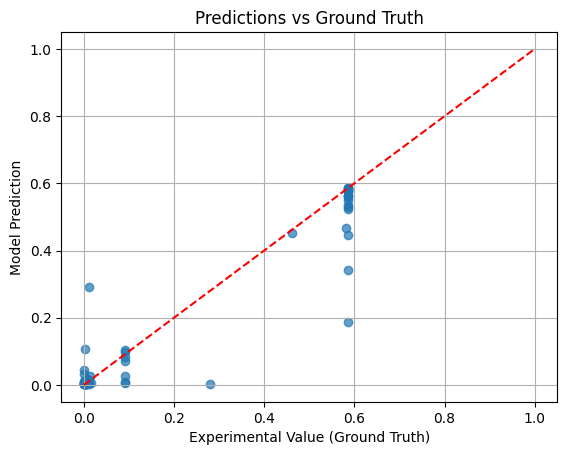

In [108]:
import matplotlib.pyplot as plt

plt.scatter(ground_truths, predictions, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("Experimental Value (Ground Truth)")
plt.ylabel("Model Prediction")
plt.title("Predictions vs Ground Truth")
plt.grid(True)
plt.show()